In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras_core as keras
from models.analytical.trapdiffusion import SingleOccupationSingleIsotope
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pathlib
from typing import Dict, Union
import yaml

Using PyTorch backend.


In [10]:
def create_dataset(dataset_name, dir = "datasets",configs = 1000, initial_per_config = 100,n_timesteps = 50, info : Union[Dict,None] = None, random_init = False, seed = None):
    bytes_per_sample = 17*8
    if configs <= 1:
        bytes_per_sample += 7*8
    total_samples = configs*initial_per_config*n_timesteps
    print(f"Estimated size: {total_samples*bytes_per_sample/1024**2} MB")
    np.random.seed(seed)
    x,y = [], []
    for _ in tqdm(range(configs), desc="configs"):
        analytical_model = SingleOccupationSingleIsotope(2,1)
        relevant_params = analytical_model.get_relevant_params()
        for _ in tqdm(range(initial_per_config), desc = "initial_values", disable=configs > 1):
            if random_init:
                c_init = np.random.random(3)
                c_init = c_init/np.sum(c_init)
            else:
                c_init = analytical_model.initial_values()
            ts, cs = analytical_model.solve(c_init,n_timesteps)
            for t,c in zip(ts,cs.T):
                training_data = [t]+list(c_init)
                if configs != 1:
                    training_data += relevant_params
                x.append(training_data)
                y.append(c)
    x,y = np.array(x), np.array(y)
    dir = pathlib.Path(dir)
    dir.mkdir(exist_ok=True)
    dataset_dir = dir.joinpath(dataset_name)
    dataset_dir.mkdir(exist_ok=True)
    np.save(dataset_dir.joinpath('x.npy'),x)
    np.save(dataset_dir.joinpath('y.npy'),y)
    if info is None:
        info = dict()
    info['configs'] = configs
    info['initial_per_params'] = initial_per_config
    info['n_timesteps'] = n_timesteps
    info['x'] = "t, c_s, c_t_1, c_t_2, relevant_params"
    info['y'] = "c_s, c_t_1, c_t_2 at time t"
    info['random_init'] = random_init
    with open(dataset_dir.joinpath('info.yaml'),'w') as f:
        yaml.safe_dump(info,f)

def load_dataset(name, dir = "datasets"):
    dir = pathlib.Path(dir)
    dataset_dir = dir.joinpath(name)
    x = np.load(dataset_dir.joinpath('x.npy'))
    y = np.load(dataset_dir.joinpath('y.npy'))
    with open(dataset_dir.joinpath('info.yaml'),'r') as f:
        info = yaml.safe_load(f)
    return x,y,info

In [95]:
create_dataset('basic',configs= 1, initial_per_config=10000,n_timesteps=100, seed = 1)

configs:   0%|          | 0/1 [00:00<?, ?it/s]

initial_values:   0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
create_dataset("full",configs=1000,initial_per_config=100,n_timesteps=50)

Estimated size: 648.49853515625 MB


configs:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
x_basic,y_basic, info_basic = load_dataset('basic')

In [23]:
# Model parameters
input_shape = (x_basic.shape[1], )

basic_model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(3,activation="relu")
    ]
)
basic_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
)
basic_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)               │        640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,539 (68.51 KB)

 Trainable params: 17,539 (68.51 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
basic_model.fit(
    x_basic,
    y_basic,
    batch_size=2**12,
    epochs=20,
    validation_split=0.15,
)


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0582 - val_loss: 2.8772e-04
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.0725e-04 - val_loss: 1.0037e-04
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 8.7650e-05 - val_loss: 6.3560e-05
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.5056e-05 - val_loss: 2.8159e-05
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.2741e-05 - val_loss: 1.4144e-05
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.2545e-05 - val_loss: 9.3817e-06
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.4276e-06 - val_loss: 6.7698e-06
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6.1316e-06 - val_loss: 4.9528e-06
Epoch 9/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.5187e-06 - val_loss: 3.7558e-06
Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.4468e-06 - val_loss: 2.9938e-06
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

In [6]:
basic_model = keras.models.load_model('trained_models/basic.keras')

TypeError: Error when deserializing class 'Dense' using config={'name': 'dense_36', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras_core.src.initializers.random_initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': 'GlorotUniform'}, 'bias_initializer': {'module': 'keras_core.src.initializers.constant_initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': 'Zeros'}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: module 'keras_core.src.activations' has no attribute 'get'

# TODO

residuum

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
(50, 3)


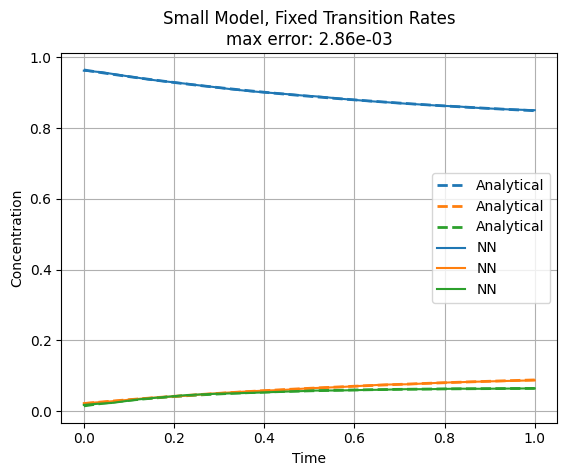

In [16]:
np.random.seed(1)
analytical_model = SingleOccupationSingleIsotope(2,1)
c_init = analytical_model.initial_values()
ts, cs = analytical_model.solve(c_init,50)
inputs = np.repeat([c_init],len(ts),axis=0)
inputs = np.append(ts.reshape(-1,1),inputs,axis=1)
predictions = basic_model.predict(inputs)
delta = np.abs(cs-predictions.T)
max_delta = np.max(delta)
colors = []
for c in cs:
    p = plt.plot(ts,c,label= "Analytical", linestyle = "--", linewidth = 2)
    colors.append(p[0].get_color())
print(predictions.shape)
for color, prediction in zip(colors,predictions.T):
    plt.plot(ts,prediction, label="NN", color=color)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title(f"Small Model, Fixed Transition Rates\nmax error: {max_delta:.2e}")
plt.legend()
plt.grid()

In [27]:
x_full,y_full, info_full = load_dataset('full')

In [57]:
# Model parameters
input_shape = (x_full.shape[1], )

full_model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(3,activation="linear")
    ]
)
full_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
)
full_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)                │        960 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_37 (Dense)                │ (None, 128)               │      8,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 256)               │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 3)                 │        771 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 43,075 (168.26 KB)

 Trainable params: 43,075 (168.26 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
full_model.fit(
    x_full,
    y_full,
    batch_size=2**12,
    epochs=200,
    validation_split=0.15,
)

Epoch 1/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 2/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 3/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 9.5389e-04 - val_loss: 0.0016
Epoch 6/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 6.6756e-04 - val_loss: 0.0015
Epoch 7/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 6.0275e-04 - val_loss: 0.0015
Epoch 8/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 7.7425e-04 - val_loss: 0.0014
Epoch 9/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 4.6770e-04 - val_loss: 0.0013
Epoch 10/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 4.2377e-04 - val_loss: 0.0013
Epoch 11/200
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 3

In [60]:
full_model.save('trained_models/full.keras')

In [7]:
full_model = keras.models.load_model('trained_models/full.keras')

TypeError: Error when deserializing class 'Dense' using config={'name': 'dense_36', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras_core.src.initializers.random_initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': 'GlorotUniform'}, 'bias_initializer': {'module': 'keras_core.src.initializers.constant_initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': 'Zeros'}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: module 'keras_core.src.activations' has no attribute 'get'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
(50, 3)


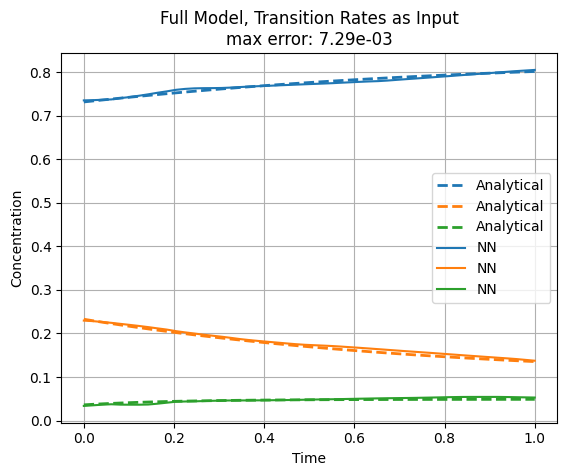

In [19]:
analytical_model = SingleOccupationSingleIsotope(2,1)
c_init = analytical_model.initial_values()
ts, cs = analytical_model.solve(c_init,50)
params = analytical_model.get_relevant_params()
inputs = np.repeat([c_init],len(ts),axis=0)
inputs = np.append(ts.reshape(-1,1),inputs,axis=1)
inputs = np.append(inputs,np.repeat([params],len(ts),axis=0),axis=1)
predictions = full_model.predict(inputs)
delta = np.abs(cs-predictions.T)
max_delta = np.max(delta)
colors = []
for c in cs:
    p = plt.plot(ts,c,label= "Analytical", linestyle = "--", linewidth = 2)
    colors.append(p[0].get_color())
print(predictions.shape)
for color, prediction in zip(colors,predictions.T):
    plt.plot(ts,prediction, label="NN", color=color)
plt.legend()
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title(f"Full Model, Transition Rates as Input\nmax error: {max_delta:.2e}")

plt.grid()